In [1]:
import logging
import tensorflow as tf


GPU_FROM = 3
GPU_TO = 4  

visible_devices = tf.config.get_visible_devices('GPU')
logging.info(f"Num GPUs visible:{len(visible_devices)}")
tf.config.set_visible_devices(visible_devices[GPU_FROM:GPU_TO],'GPU')

visible_devices = tf.config.get_visible_devices('GPU')
logging.info(f"Num GPUs to be used: {len(visible_devices)}")

2023-02-23 13:07:39.435795: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-23 13:07:39.572776: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-23 13:07:39.608290: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-23 13:07:40.267794: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
import numpy as np
import string

FULL_VOCAB = string.ascii_lowercase
SEQ_LEN = 100

def dataset1(vocab_size=2, dataset_size=10000, seq_len=10, full_vocab=FULL_VOCAB):
  """
  Inserts a space after a the first character in the vocabulary (and nowhere else)
  """
  assert vocab_size > 1
  vocab = list(full_vocab[:vocab_size])
  inputs = np.random.choice(vocab, size=(dataset_size, seq_len))
  outputs = np.where(inputs == vocab[0], 1., 0.).astype(np.float32)  # 1 = space, 0 = no space
  concatenated_inputs = np.array([''.join(row) for row in inputs])
  return concatenated_inputs, outputs

def dataset2(vocab_size=2, dataset_size=10000, seq_len=10, full_vocab=FULL_VOCAB):
  """
  Inserts a space after the combination of 1st->2nd character in the vocabulary (and nowhere else)
  """
  assert vocab_size > 1
  vocab = list(full_vocab[:vocab_size])
  inputs = np.random.choice(vocab, size=(dataset_size, seq_len))
  outputs = np.ones_like(inputs, dtype=np.float32)
  for i, example in enumerate(inputs):
    previous_char = example[0]
    for j, char in enumerate(example[1:]):
      if (previous_char == vocab[0]) and (char == vocab[1]):  # 1 = space, 0 = no space
        outputs[i, j+1] = 2.
      previous_char = char
  concatenated_inputs = np.array([''.join(row) for row in inputs])
  return concatenated_inputs, outputs

def dataset3(vocab_size=2, dataset_size=10000, seq_len=10, insert_space_every=3, full_vocab=FULL_VOCAB):
  """
  Inserts a space after a certain number of characters, no matter what the characters
  """
  assert vocab_size > 1
  vocab = list(full_vocab[:vocab_size])
  inputs = np.random.choice(vocab, size=(dataset_size, seq_len))
  outputs = np.zeros_like(inputs, dtype=np.float32)
  outputs[:, np.arange(insert_space_every-1, outputs.shape[1], insert_space_every)] = 1.
  concatenated_inputs = np.array([''.join(row) for row in inputs])
  return concatenated_inputs, outputs

In [3]:
DATASET_FN = dataset2

train_ds = tf.data.Dataset.from_tensor_slices(DATASET_FN(vocab_size=2, seq_len=SEQ_LEN))
valid_ds = tf.data.Dataset.from_tensor_slices(DATASET_FN(vocab_size=2, seq_len=SEQ_LEN))
test_ds = tf.data.Dataset.from_tensor_slices(DATASET_FN(vocab_size=2, seq_len=SEQ_LEN))
train_ds.element_spec

2023-02-23 13:07:42.117207: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-23 13:07:42.798452: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22296 MB memory:  -> device: 3, name: GeForce RTX 3090, pci bus id: 0000:d8:00.0, compute capability: 8.6


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(100,), dtype=tf.float32, name=None))

In [4]:
tokenizer = tf.keras.layers.TextVectorization(
    output_sequence_length=100,
    standardize="lower_and_strip_punctuation",
    split="character",
    output_mode="int",
)

tokenizer.adapt(train_ds.take(10).map(lambda x,y: x))
tokenizer.get_vocabulary()

['', '[UNK]', 'a', 'b']

In [5]:
tokenizer("ababab")

<tf.Tensor: shape=(100,), dtype=int64, numpy=
array([2, 3, 2, 3, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])>

In [6]:
from segmentation.model import Encoder
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Encoder(
        num_layers=2,
        d_model=32,
        num_attention_heads=2,
        dff=32,
        seq_len=100,
        tokenizer=tokenizer
    ),
    Dense(3, activation="softmax")
])

In [7]:
from segmentation.metrics import SparseAccuracyWithIgnore
from segmentation.metrics import SparsePrecision
from segmentation.metrics import SparseRecall
from segmentation.metrics import SparseF1

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, ignore_class=0), # Why can I not ignore class 0?
    metrics=[
        SparseAccuracyWithIgnore(ignore_token=0),
        SparsePrecision(class_id=2, name="space_precision"),
        SparseRecall(class_id=2, name="space_recall"),
        SparseF1(class_id=2, name="space_f1"),
        SparsePrecision(class_id=1, name="char_precision"),
        SparseRecall(class_id=1, name="char_recall"),
        SparseF1(class_id=1, name="char_f1"),
    ]
)

In [8]:
batched_train = train_ds.shuffle(100).batch(8)
batched_val = valid_ds.batch(8)

model.fit(batched_train, validation_data=batched_val, epochs=10)

Epoch 1/10
   7/1250 [..............................] - ETA: 25s - loss: 0.9006 - sparse_categorical_accuracy: 0.5945 - space_precision: 0.3445 - space_recall: 0.3038 - space_f1: 0.3229 - char_precision: 0.7833 - char_recall: 0.6903 - char_f1: 0.7339   

2023-02-23 13:07:49.883763: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1250/1250 [==============================] - 45s 32ms/step - loss: 0.3037 - sparse_categorical_accuracy: 0.8107 - space_precision: 0.6213 - space_recall: 0.6065 - space_f1: 0.6138 - char_precision: 0.8718 - char_recall: 0.8778 - char_f1: 0.8748 - val_loss: 0.0277 - val_sparse_categorical_accuracy: 1.0000 - val_space_precision: 1.0000 - val_space_recall: 1.0000 - val_space_f1: 1.0000 - val_char_precision: 1.0000 - val_char_recall: 1.0000 - val_char_f1: 1.0000
Epoch 2/10
1250/1250 [==============================] - 39s 31ms/step - loss: 0.1244 - sparse_categorical_accuracy: 0.9418 - space_precision: 0.8867 - space_recall: 0.8767 - space_f1: 0.8817 - char_precision: 0.9596 - char_recall: 0.9632 - char_f1: 0.9614 - val_loss: 0.0121 - val_sparse_categorical_accuracy: 1.0000 - val_space_precision: 1.0000 - val_space_recall: 1.0000 - val_space_f1: 1.0000 - val_char_precision: 1.0000 - val_char_recall: 1.0000 - val_char_f1: 1.0000
Epoch 3/10
1250/1250 [==============================] - 39s 31m

In [9]:
model.evaluate(batched_val)

1250/1250 [==============================] - 16s 12ms/step - loss: 2.1019e-04 - sparse_categorical_accuracy: 1.0000 - space_precision: 1.0000 - space_recall: 1.0000 - space_f1: 1.0000 - char_precision: 1.0000 - char_recall: 1.0000 - char_f1: 1.0000


[0.0002101940190186724, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [13]:
test_inputs = tf.constant(("5554445", "55544455554445", "5454545454545454"))
preds = model(test_inputs)
truth = tf.ragged.constant([[1,1,1,1,1,1,2], [1,1,1,1,1,1,2,1,1,1,1,1,1,2], [1,1,2, 1,2, 1,2, 1,2, 1,2, 1,2, 1,2, 1]])
char_conditional = (truth == 1).to_tensor(False, shape=(truth.shape[0],100))
space_conditional = (truth == 2).to_tensor(False, shape=(truth.shape[0],100))

In [21]:
tf.argmax(preds, axis=-1), preds

(<tf.Tensor: shape=(3, 100), dtype=int64, numpy=
 array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1

Text(0.5, 0.98, 'Probabilities of space/char conditional on character input')

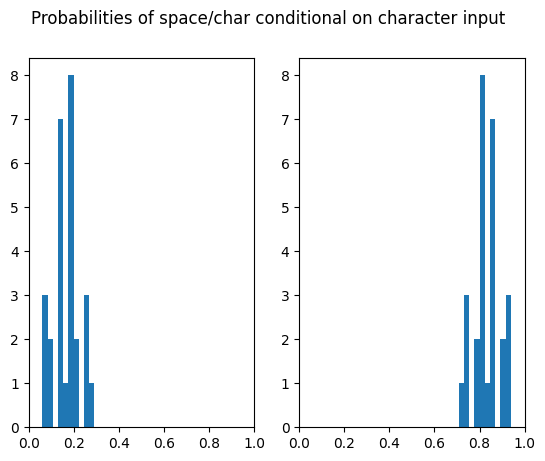

In [16]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2)
prob_of_space = preds[char_conditional][...,2]
prob_of_char = preds[char_conditional][...,1]
axs[0].hist(prob_of_space)
axs[0].set_xlim(0,1)
axs[1].hist(prob_of_char)
axs[1].set_xlim(0,1)
fig.suptitle("Probabilities of space/char conditional on character input")

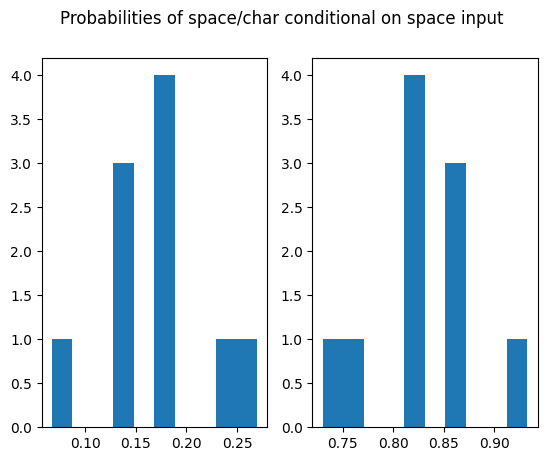

In [17]:
fig, axs = plt.subplots(1,2)
prob_of_space = preds[space_conditional][...,2]
prob_of_char = preds[space_conditional][...,1]
axs[0].hist(prob_of_space)
axs[1].hist(prob_of_char)
# axs[1].set_xlim(0,1)
fig.suptitle("Probabilities of space/char conditional on space input")

fig.show()

In [18]:
list(prob_of_char.numpy()), prob_of_space

([0.8193382,
  0.81240076,
  0.7538239,
  0.86560094,
  0.86142373,
  0.81190264,
  0.8673313,
  0.9328213,
  0.8122262,
  0.73024666],
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([0.1806618 , 0.18759923, 0.24617611, 0.13439906, 0.13857625,
        0.18809737, 0.13266864, 0.06717877, 0.18777378, 0.2697533 ],
       dtype=float32)>)

In [19]:
[len(x) for x in test_inputs[0]], preds._keras_mask.numpy().sum(axis=1)

TypeError: Cannot iterate over a scalar tensor.

In [20]:
pos = model.encoder.pos_embedding.pos_encoding.numpy()
learned_embed = model.encoder.pos_embedding.embedding.embeddings.numpy()
tf.reduce_sum(pos@pos.T,axis=-1), tf.reduce_sum(learned_embed@learned_embed.T,axis=-1)

AttributeError: 'Sequential' object has no attribute 'encoder'